In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from time import perf_counter 
import os
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import accuracy_score

In [3]:
## Defining batch specfications
batch_size = 100
img_height = 250
img_width = 250

In [4]:
## loading training set
training_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/train',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 791 files belonging to 2 classes.


In [5]:
## loading validation dataset
validation_data =  tf.keras.preprocessing.image_dataset_from_directory(
    'data/val',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 98 files belonging to 2 classes.


In [6]:
## loading testing dataset
testing_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data/test',
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size,
    color_mode='rgb'
)

Found 100 files belonging to 2 classes.


In [7]:
testing_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 250, 250, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
class_names = training_data.class_names
class_names

['Accident', 'Non Accident']

In [9]:
## Configuring dataset for performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
training_data = training_data.cache().prefetch(buffer_size=AUTOTUNE)
testing_data = testing_data.cache().prefetch(buffer_size=AUTOTUNE)

In [10]:
## Defining Cnn
model = tf.keras.models.Sequential([
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, activation='relu'), 
  layers.MaxPooling2D(), 
  layers.Conv2D(64, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.Dense(len(class_names), activation= 'softmax')
])

model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [11]:
model.build((None, 250, 250, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 250, 250, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 248, 248, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 124, 124, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 64)       0         
 2D)                                                             
                                                        

In [12]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
## lets train our CNN
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(training_data, validation_data=validation_data, epochs = 20, callbacks=callbacks_list)

Epoch 1/20
8/8 [==============================] - ETA: 0s - loss: 3.1935 - accuracy: 0.4728
Epoch 1: val_accuracy improved from -inf to 0.46939, saving model to model_weights.h5
8/8 [==============================] - 76s 9s/step - loss: 3.1935 - accuracy: 0.4728 - val_loss: 0.7205 - val_accuracy: 0.4694
Epoch 2/20
8/8 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5461
Epoch 2: val_accuracy improved from 0.46939 to 0.53061, saving model to model_weights.h5
8/8 [==============================] - 68s 9s/step - loss: 0.6910 - accuracy: 0.5461 - val_loss: 0.6834 - val_accuracy: 0.5306
Epoch 3/20
8/8 [==============================] - ETA: 0s - loss: 0.6750 - accuracy: 0.5866
Epoch 3: val_accuracy improved from 0.53061 to 0.64286, saving model to model_weights.h5
8/8 [==============================] - 67s 8s/step - loss: 0.6750 - accuracy: 0.5866 - val_loss: 0.6593 - val_accuracy: 0.6429
Epoch 4/20
8/8 [==============================] - ETA: 0s - loss: 0.6427 - accu

In [13]:
###### serialize model structure to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [22]:
print("Training Accuracy :")
print(history.history['accuracy'][-1])

Training Accuracy :
0.9797724485397339


In [23]:
print("Test Accuracy :")
print(history.history['val_accuracy'][-1])

Test Accuracy :
0.8877550959587097


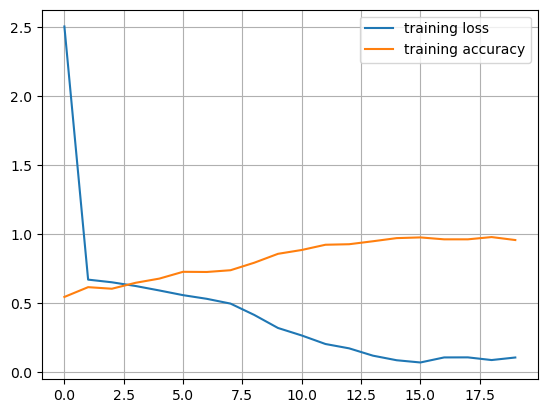

In [14]:
## stats on training data
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.grid(True)
plt.legend()

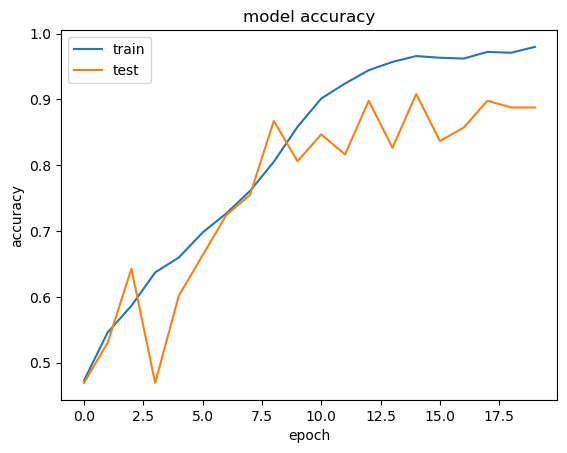

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


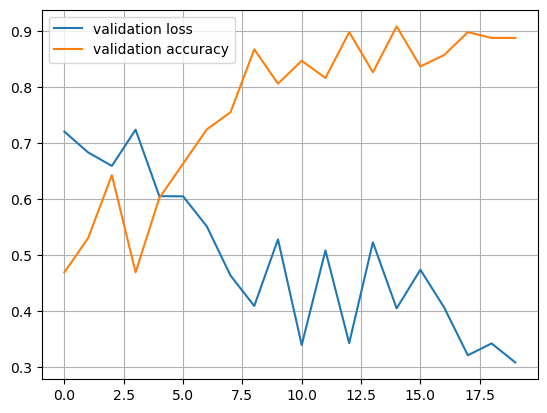

In [15]:
## stats on training data
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.legend()

4/4 [==============================] - 2s 456ms/step


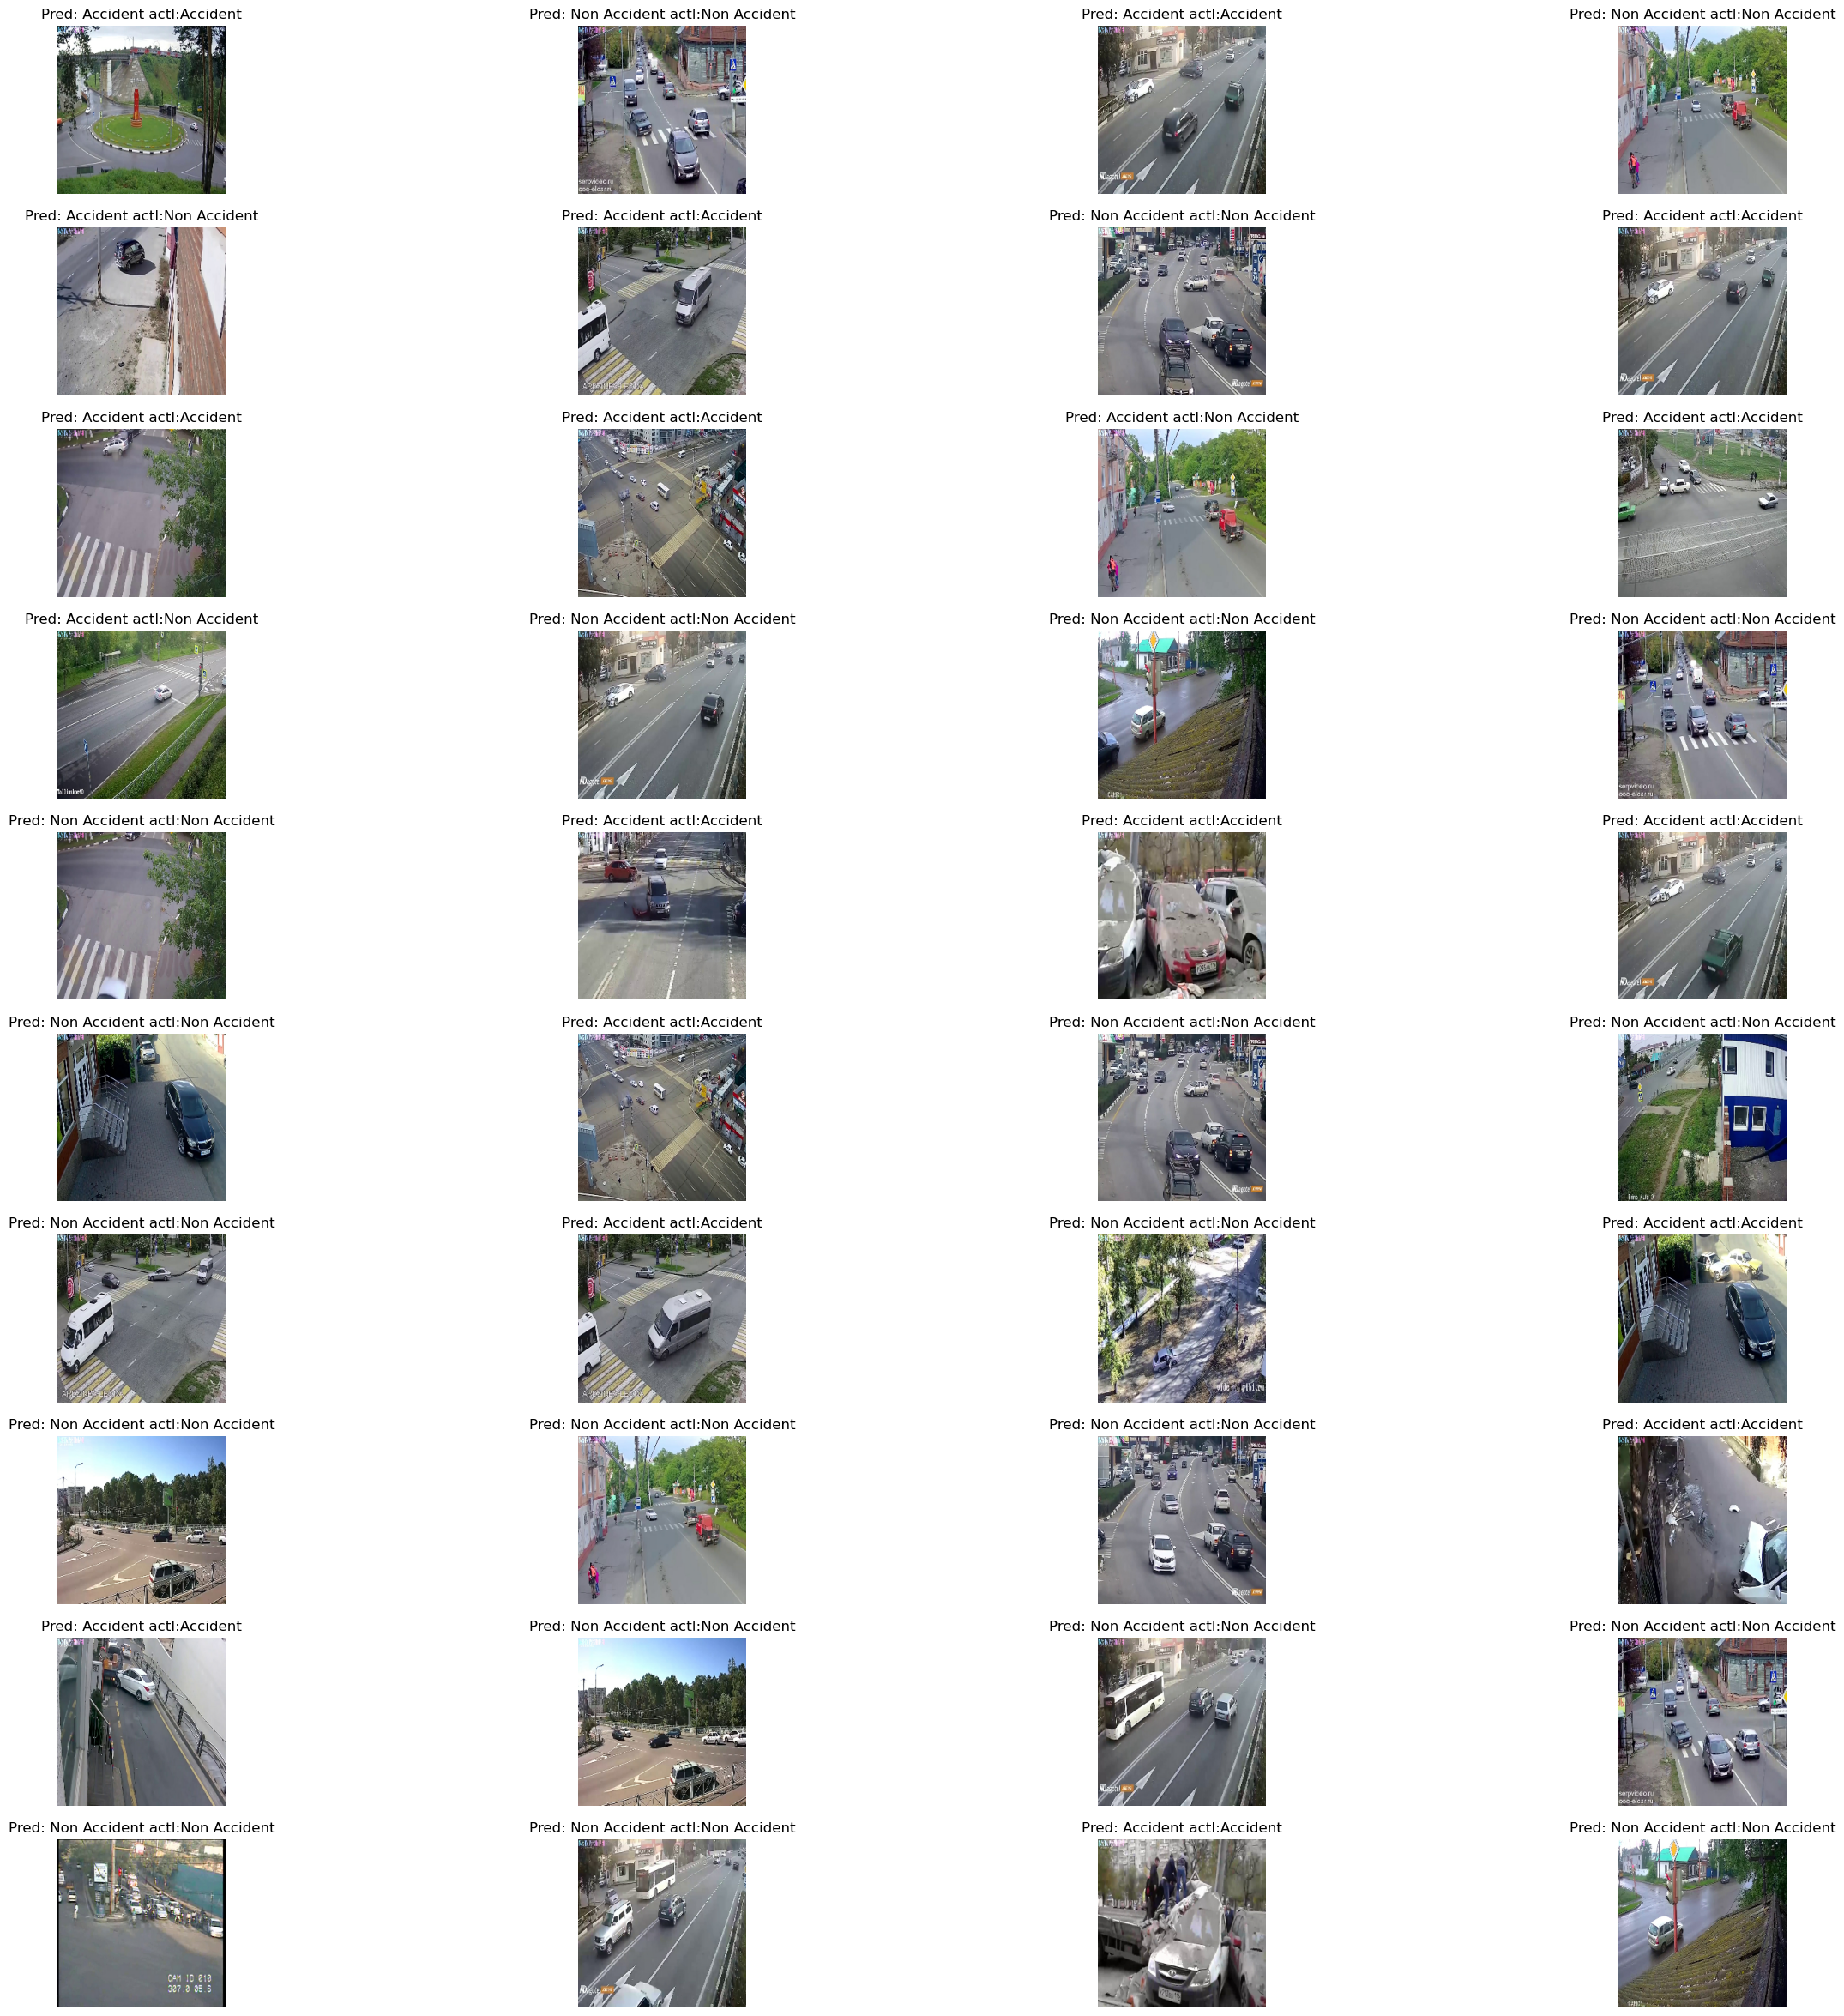

In [17]:
AccuracyVector = []
plt.figure(figsize=(30, 30))
for images, labels in testing_data.take(1):
    predictions = model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Pred: '+ predlabel[i]+' actl:'+class_names[labels[i]] )
        plt.axis('off')
        plt.grid(True)

In [19]:
print(history.history['accuracy'][-1])

0.9797724485397339
